In [3]:
import bempp.api as bem
import numpy as np

def perturbate(grid, t, kappa_pert=None):
    P1 = bem.function_space(grid, 'P', 1)
    grid_funz = bem.GridFunction(P1, fun = Phiz)
    elements = grid.leaf_view.elements
    vertices = grid.leaf_view.vertices
    normals = P1.global_dof_normals
    x, y, z = vertices
    
    vertices[2, :] = z + t * grid_funz.coefficients
    return bem.grid_from_element_data(vertices, elements)
    
def dirichlet_fun(x, n, domain_index, result):
    result[0] = np.exp(1j * k0 * x[0])

def neumann_fun(x, n, domain_index, result):
    result[0] = 1j * k0 * np.exp(1j * k0 * x[0]) * n[0]


def Phiz(point, n, domain_index, result):
    x, y, z = point
    if z == 0.5 and (y <= 0.5) and (z <= 0.5):
        result[0] = np.sin(np.pi*x*2) * np.sin(np.pi*y*2)
    else:
        result[0] = 0
 


k0 = 3
precision = 10

#tolerance = 1E-7

h = 2.0 * np.pi / (precision * k0)
tolerance = 10E-4
grid = bem.shapes.reentrant_cube(h=h)

print(grid.leaf_view.entity_count(0))
def solver(grid):
    space = bem.function_space(grid, 'DP', 0)	
    V = bem.operators.boundary.helmholtz.single_layer(space, space, space, k0)
    K = bem.operators.boundary.helmholtz.double_layer(space, space, space, k0)
    I = bem.operators.boundary.sparse.identity(space, space, space)
    df =  bem.GridFunction(space , fun = dirichlet_fun)
    phi, info, res = bem.linalg.gmres(V, df, tol=tolerance, return_residuals=True, use_strong_form=False, maxiter=1000, restart=1000)
    slp_far_field = bem.operators.far_field.helmholtz.single_layer(space, points, k0)
    U = -slp_far_field * phi
    return U





theta = np.linspace(0, 2 * np.pi, 400)
points = np.array([np.cos(theta), np.sin(theta), np.zeros(len(theta))])

space = bem.function_space(grid, 'DP', 0)	

V = bem.operators.boundary.helmholtz.single_layer(space, space, space, k0)
K = bem.operators.boundary.helmholtz.double_layer(space, space, space, k0)
I = bem.operators.boundary.sparse.identity(space, space, space)

df =  bem.GridFunction(space , fun = dirichlet_fun)

phi, info, res = bem.linalg.gmres(V, df, tol=tolerance, return_residuals=True, use_strong_form=False, maxiter=1000, restart=1000)

kappa = bem.GridFunction(space, fun = Phiz)
fun1 = bem.GridFunction(space, coefficients = kappa.coefficients * phi.coefficients)
rhs1 = -0.5 * I + K
rhsp = rhs1 * (-fun1)
phi1, info, res = bem.linalg.gmres(V, rhsp,  tol=tolerance, return_residuals=True, use_strong_form=False, maxiter=1000, restart=1000)



phi2, info, res = bem.linalg.gmres(V, -fun1,  tol=tolerance, return_residuals=True, use_strong_form=False, maxiter=1000, restart=1000)



slp_far_field = bem.operators.far_field.helmholtz.single_layer(space, points, k0)
dlp_far_field = bem.operators.far_field.helmholtz.double_layer(space, points, k0)


t = 1

U = -slp_far_field * phi
U1 =  -slp_far_field * phi1 + dlp_far_field * (-fun1)

U12 =  slp_far_field * phi2
grt = gridt = perturbate(grid, t)
Ut = solver(grt)
Up = U + t * U1


############
coeff = 1/12.* 1/4.
variance = coeff * U1 * np.conj(U1)




from matplotlib import pyplot as plt
fig = plt.figure()
angles = np.pi * np.linspace(0, 1, 400)





516


/usr/lib/python3/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/lib/python3/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


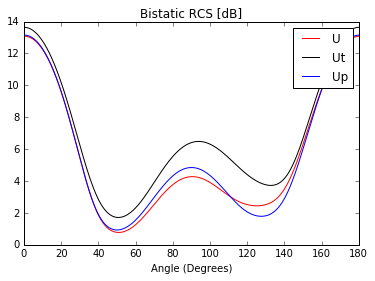

In [4]:
fig = plt.figure()

bistatic_rcs= 10 * np.log10(4 * np.pi * np.sum(np.abs(U)**2, axis=0))
plt.plot(angles * 180 / np.pi, bistatic_rcs, label='U',color='r' )

bistatic_rcs= 10 * np.log10(4 * np.pi * np.sum(np.abs(Ut)**2, axis=0))
plt.plot(angles * 180 / np.pi, bistatic_rcs, label='Ut',color='k' )

bistatic_rcs= 10 * np.log10(4 * np.pi * np.sum(np.abs(Up)**2, axis=0))
plt.plot(angles * 180 / np.pi, bistatic_rcs, label='Up',color='b' )


#plt.plot(angles * 180 / np.pi, bistatic_rcst, label='Ut')
plt.title("Bistatic RCS [dB]")
plt.xlabel('Angle (Degrees)')
plt.legend()
plt.show()